***Dependencies***

In [1]:
# !pip install gpytorch
# !pip install botorch
# !pip install matplotlib

In [2]:
"""Import Statements which we will need"""
from botorch.acquisition import ExpectedImprovement 
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.acquisition.objective import  IdentityMCObjective 
from botorch.exceptions import BadInitialCandidatesWarning
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.optim.initializers import initialize_q_batch_nonneg
from botorch.sampling import SobolQMCNormalSampler 
from botorch.test_functions import Beale, Branin, Hartmann  
from botorch.utils import standardize, t_batch_mode_transform

from bo_helper_functions import (normalize, unnormalize, objective, get_random_observations, generate_initial_data,
                                 sigmoid, generate_cost, initialize_model, optimize_acqf_and_get_observation)
from eeipu_variants import EIPUVariants
  
from gpytorch.kernels import MaternKernel, LinearKernel, PiecewisePolynomialKernel, PolynomialKernel, RBFKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from matplotlib import pyplot as plt

import botorch 
import gpytorch 
import numpy as np
import os
import random
import torch
import warnings

## **1. Setup** 


In [3]:
'''Parameters for how the code runs
Note: true algorithm hyperparameters are defined in the main loop'''

# Add 5, asterisks `#*****`, to the end of any line we modified or added from -> ||  https://botorch.org/v/0.1.4/tutorials/closed_loop_botorch_only '''

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning) #*****

Text(0.5, 1.0, 'logistic function')

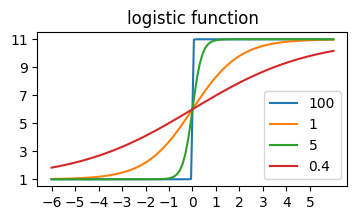

In [4]:
logistic = lambda z, const: 1./ (1 + np.exp(-const*z))       #logistic function
z = np.linspace(-6,6,100)
plt.subplots(1, 1, figsize=(4, 2))
plt.plot(z, logistic(z, 100)*10 + 1, label="100")
plt.plot(z, logistic(z, 1)*10 + 1, label="1")
plt.plot(z, logistic(z, 5)*10 + 1, label="5")
plt.plot(z, logistic(z, 0.4)*10 + 1, label="0.4")
plt.xticks(np.arange(-6,6,1))
plt.yticks(np.arange(1, 13, 2)) 
plt.legend(loc="lower right")

plt.title('logistic function')



## **2. Single BO Step**  

In [5]:
def single_bo_iteration(dataset={}, bounds={}, acq_type='', cfg={}):
    cost_model, cost_sampler={}, {}
    # (A) Normalize the dataset Points (only normalize cost if we are using acqfunc that needs cost model)
    # NOTE: single-line if statements used here
    if (cfg['normalize_bit']['x']==True and acq_type!='RAND'):
        train_x = normalize(dataset['x'], norm_type='x', bounds=bounds['x']) 
    else:
        train_x = dataset['x']
    if (cfg['normalize_bit']['y']==True and acq_type!='RAND'):
        train_obj = normalize(dataset['y'], norm_type='y', bounds=bounds['y'])   
    else:
        train_obj = dataset['y']
    if acq_type=='EEIPU': # cover potential cost model value normalisation
        if (cfg['normalize_bit']['c']==True and acq_type!='RAND'): 
            train_cost = normalize(dataset['c'], norm_type='c', bounds=bounds['c']) 
        else:
            train_cost = dataset['c']
    if acq_type=='EEIPU-INV': # cover potential inverse cost model value normalisation
        if (cfg['normalize_bit']['1/c'] and acq_type!='RAND'):
            train_cost = normalize(dataset['1/c'], norm_type='1/c', bounds=bounds['1/c'])  
        else:
            train_cost = dataset['1/c']

    # (B) Initialise/Re-initialize & Fit/Refit the GP models (only initialise cost model if we'll need it)
    mll, model= initialize_model(train_x, train_obj) 
    fit_gpytorch_model(mll);
    if acq_type in ['EEIPU', 'EEIPU-INV']: 
        cost_mll, cost_model= initialize_model(train_x, train_cost, cost_kernel=cfg['cost_kernel'])  
        fit_gpytorch_model(cost_mll)

    # (C) Redefine acquisition function & optimise  
    if (acq_type=='RAND'):
        acqf = 'RAND'
    elif (acq_type=='EI'):
        acqf = ExpectedImprovement(model=model, best_f=train_obj.max())
    elif (acq_type=='EIPU') or (acq_type=='EEIPU') or (acq_type=='EEIPU-INV'):
        cost_sampler = SobolQMCNormalSampler(num_samples=cfg['cost_samples'], resample=True, seed=cfg['rand_seed'])
        acqf = EIPUVariants(acq_type=acq_type, model=model, cost_model=cost_model, 
                 best_f=train_obj.max(), 
                 cost_sampler=cost_sampler, acq_objective=IdentityMCObjective(),   
                 cost_func=generate_cost, unnormalise_func=unnormalize, bounds=bounds,
                 cfg=cfg)
 
    if acq_type == 'RAND':
        new_x = optimize_acqf_and_get_observation(batch_size=cfg['batch_size'], acq_func=acq_type, 
                                              optim_bounds=bounds['x'], r_seed=cfg['rand_seed']) # includes random search option, for code neatness 
    else: # careful with bounds for non random acqfunctions - single line if statement used here
        normalised_bounds = normalize(bounds['x'], norm_type='x', bounds=bounds['x']) if cfg['normalize_bit']['x'] else bounds['x']  # Need too normalize the bounds used in the acqfunction too!
        new_x = optimize_acqf_and_get_observation(batch_size=cfg['batch_size'], acq_func=acqf,  # includes random search option, for code neatness 
                                            optim_bounds=normalised_bounds, r_seed=cfg['rand_seed'])
    # (D) Unnormalize the X value and return (also mc cost or analytic inverse cost, since we can't compute outside this func)
    cost_model_mean = torch.tensor([0]); 
    if acq_type == 'EEIPU': cost_model_mean = acqf.compute_expected_cost(new_x)
    if acq_type == 'EEIPU-INV': cost_model_mean = acqf.direct_expected_inverse_cost(new_x)
    if cfg['normalize_bit']['x'] and acq_type != 'RAND' : new_x = unnormalize(new_x, norm_type='x', orig_bounds=bounds['x'])# cat with unnormalised x here
    return new_x, cost_model_mean
   


## **3.0 BO Inner Loops (Multiple Steps)**  

In [6]:
def bo_inner_loops(trial_number=None, x_bounds=None, acq_type='', cfg={}):
    print(f"TRIAL #{trial_number} Acq-Type: [{acq_type}]")
    log_vals  = {'f(x^)': [],'x': [], 'f(x)': [], 'c(x)': [], 'mc(x)': [], '1/c(x)': [], 'c(c)':[]} # f(x^) = best obj val so far; c(c) is cumulative cost  

    dataset, bounds = {},{}
    # (A) Initialize dataset for all the different acq function types  
    dataset['x'], dataset['y'] = generate_initial_data(n=cfg['num_initial_data'], bounds=x_bounds, trial_seed=trial_number, cfg=cfg); 
    dataset['c'] = generate_cost(dataset['x'], cfg=cfg) 
    dataset['1/c'] = 1/dataset['c'] 

    log_vals['c(c)'].append(dataset['c'].sum().item())
    log_vals['f(x^)'].append(objective(dataset['x'], cfg=cfg).max().item())

    # (B) run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(cfg['n_iters']):    
        bounds['x'] = x_bounds # bounds written as min,max not max,min
        bounds['y'] = torch.tensor([[dataset['y'].min()], [dataset['y'].max()]], device=cfg['device'], dtype=cfg['dtype'])
        bounds['c'] = torch.tensor([[dataset['c'].min()], [dataset['c'].max()]], device=cfg['device'], dtype=cfg['dtype'])
        bounds['1/c'] = torch.tensor([[dataset['1/c'].min()], [dataset['1/c'].max()]], device=cfg['device'], dtype=cfg['dtype'])

        # (B.0) At each single iteration, we pass the dataset and take the next suggested point
        new_x, mc_x = single_bo_iteration(dataset=dataset, bounds=bounds, acq_type=acq_type, cfg=cfg )

        new_obj = objective(new_x, cfg=cfg).unsqueeze(-1)  # add output dimension 
        new_cost = generate_cost(new_x, cfg=cfg)  

        dataset['x'] = torch.cat([dataset['x'], new_x]) 
        dataset['y'] = torch.cat([dataset['y'], new_obj])  
        dataset['c'] = torch.cat([dataset['c'], new_cost])       
        dataset['1/c'] = torch.cat([dataset['1/c'], 1/new_cost])       

        log_vals['f(x^)'].append(objective(dataset['x'], cfg=cfg).max().item())
        log_vals['x'] = np.array(new_x.cpu())
        log_vals['f(x)'].append(new_obj.item())
        log_vals['c(x)'].append(new_cost.item())
        log_vals['c(c)'].append(log_vals['c(c)'][-1]+ new_cost.item())
        log_vals['mc(x)'].append(mc_x.item()) 
        log_vals['1/c(x)'].append((1/new_cost).item())

        if cfg['verbose']:
            print(f"Iteration-{iteration} [{acq_type}] Trial No. #{trial_number}"
              f"\nf(x^)={log_vals['f(x^)'][-1]:>4.3f}"
              f"\tf(x)={log_vals['f(x)'][-1]:>4.3f}"
              f"\tc(x) = {log_vals['c(x)'][-1]:>4.3f}"
              f"\tmc(x) = {log_vals['mc(x)'][-1]:>4.3f}" 
              f"\t1/c(x) = {log_vals['1/c(x)'][-1]:>4.3f}" 
              f"\tc(c) = {log_vals['c(c)'][-1]:>4.3f}")

    return log_vals

## **3.1. BO Outer Loops (Multiple Trials)**  

In [7]:
def bo_trials(cfg={}, acq_type=''):

    torch.manual_seed(seed=cfg['rand_seed'])
    np.random.seed(cfg['rand_seed'])
    random.seed(cfg['rand_seed'])
    botorch.utils.sampling.manual_seed(seed=cfg['rand_seed'])
    # https://github.com/pytorch/botorch/issues/371


    x_bounds = torch.tensor([[cfg['x_bounds'][0]] * cfg['fxn_dim'], [cfg['x_bounds'][1]] * cfg['fxn_dim']], device=cfg['device'], dtype=cfg['dtype'])
    log_vals_all  = {'f(x^)': [],'x': [], 'f(x)': [], 'c(x)': [], 'mc(x)': [], 'c(c)':[]}
    print("\n\nnormalize_bit", cfg['normalize_bit'])
    # average over multiple trials
    for trial in range(1, cfg['n_trials'] + 1):

        log_vals = bo_inner_loops(trial_number=trial, x_bounds=x_bounds, acq_type=acq_type, cfg=main_cfg)

        for key in log_vals_all.keys():
            log_vals_all[key].append(log_vals[key])
            if trial==cfg['n_trials']: log_vals_all[key] = np.array(log_vals_all[key])# save as np array on the last trial    
    return log_vals_all



## **3.2. BO Methods (Multiple Acquisitions)**  

In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 2080 Ti


In [9]:
# Batch size in original tutorial meant q-batch size https://botorch.org/v/0.1.4/tutorials/closed_loop_botorch_only ||  # lower bound and upper bound could be -float('inf') ~ float('inf')
main_cfg = {
'batch_size':1, 'x_bounds': [-5,5],  
'CONSTANT':.5,
'cost_samples': 50, # mc cost samples
'cost_kernel': None, 
'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"), 'dtype': torch.double,
'fxn_name':'branin_4d', # {'test':3, 'branin_4d':4, 'beale_hartmann_7d':7,  'branin_hartmann_8d':8},   
'fxn_dim':4, # {'test':3, 'branin_4d':4, 'beale_hartmann_7d':7,  'branin_hartmann_8d':8},   
'neg_hartmann6':Hartmann(negate=True),
'neg_beale2':Beale(negate=True),
'neg_branin2':Branin(negate=True),
'neg_hartmann3':Hartmann(dim=3, negate=True), 
'n_trials':10,
'n_iters':30,
'num_initial_data':10,
'verbose':True,
'normalize_bit':{'x':True, 'y':True, 'c':True, '1/c':True}, 
'rand_seed': 0,
}
 
# (C) Do the above for each of the different acquisition function types
plot_vals = {}

plot_vals['RAND'] = bo_trials(cfg=main_cfg, acq_type='RAND') 
# plot_vals['RAND2'] = bo_trials(cfg=main_cfg, acq_type='RAND')  
plot_vals['EI'] = bo_trials(cfg=main_cfg, acq_type='EI') 
plot_vals['EIPU'] = bo_trials(cfg=main_cfg, acq_type='EIPU') 
plot_vals['EEIPU'] = bo_trials(cfg=main_cfg, acq_type='EEIPU') 
plot_vals['EEIPU-INV'] = bo_trials(cfg=main_cfg, acq_type='EEIPU-INV') 
# dfsdsdfsd




normalize_bit {'x': True, 'y': True, 'c': True, '1/c': True}
TRIAL #1 Acq-Type: [RAND]
Iteration-0 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-247.106	c(x) = 7.384	mc(x) = 0.000	1/c(x) = 0.135	c(c) = 78.636
Iteration-1 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-33.581	c(x) = 13.877	mc(x) = 0.000	1/c(x) = 0.072	c(c) = 92.512
Iteration-2 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-88.179	c(x) = 10.889	mc(x) = 0.000	1/c(x) = 0.092	c(c) = 103.401
Iteration-3 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-73.974	c(x) = 10.966	mc(x) = 0.000	1/c(x) = 0.091	c(c) = 114.367
Iteration-4 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-58.352	c(x) = 10.694	mc(x) = 0.000	1/c(x) = 0.094	c(c) = 125.061
Iteration-5 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-122.731	c(x) = 8.220	mc(x) = 0.000	1/c(x) = 0.122	c(c) = 133.282
Iteration-6 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-130.491	c(x) = 2.670	mc(x) = 0.000	1/c(x) = 0.374	c(c) = 135.952
Iteration-7 [RAND] Trial No. #1
f(x^)=-19.246	f(x)=-45.071	c(x) = 9.963	mc(x) = 0.000	1/c(x) =

Iteration-9 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-213.772	c(x) = 0.048	mc(x) = 0.000	1/c(x) = 20.637	c(c) = 139.030
Iteration-10 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-115.721	c(x) = 9.698	mc(x) = 0.000	1/c(x) = 0.103	c(c) = 148.728
Iteration-11 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-16.059	c(x) = 19.242	mc(x) = 0.000	1/c(x) = 0.052	c(c) = 167.970
Iteration-12 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-163.886	c(x) = -2.480	mc(x) = 0.000	1/c(x) = -0.403	c(c) = 165.490
Iteration-13 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-45.241	c(x) = 6.230	mc(x) = 0.000	1/c(x) = 0.161	c(c) = 171.720
Iteration-14 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-79.655	c(x) = 4.970	mc(x) = 0.000	1/c(x) = 0.201	c(c) = 176.690
Iteration-15 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-570.188	c(x) = -7.816	mc(x) = 0.000	1/c(x) = -0.128	c(c) = 168.873
Iteration-16 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-437.639	c(x) = -5.757	mc(x) = 0.000	1/c(x) = -0.174	c(c) = 163.117
Iteration-17 [RAND] Trial No. #3
f(x^)=-7.540	f(x)=-241.455	

Iteration-19 [RAND] Trial No. #5
f(x^)=-18.273	f(x)=-159.209	c(x) = 0.586	mc(x) = 0.000	1/c(x) = 1.708	c(c) = 153.259
Iteration-20 [RAND] Trial No. #5
f(x^)=-18.273	f(x)=-122.194	c(x) = 5.259	mc(x) = 0.000	1/c(x) = 0.190	c(c) = 158.518
Iteration-21 [RAND] Trial No. #5
f(x^)=-18.273	f(x)=-373.820	c(x) = 0.805	mc(x) = 0.000	1/c(x) = 1.242	c(c) = 159.323
Iteration-22 [RAND] Trial No. #5
f(x^)=-18.273	f(x)=-32.969	c(x) = 13.302	mc(x) = 0.000	1/c(x) = 0.075	c(c) = 172.625
Iteration-23 [RAND] Trial No. #5
f(x^)=-8.114	f(x)=-8.114	c(x) = 19.274	mc(x) = 0.000	1/c(x) = 0.052	c(c) = 191.900
Iteration-24 [RAND] Trial No. #5
f(x^)=-8.114	f(x)=-361.990	c(x) = -6.836	mc(x) = 0.000	1/c(x) = -0.146	c(c) = 185.063
Iteration-25 [RAND] Trial No. #5
f(x^)=-8.114	f(x)=-185.233	c(x) = 3.032	mc(x) = 0.000	1/c(x) = 0.330	c(c) = 188.095
Iteration-26 [RAND] Trial No. #5
f(x^)=-8.114	f(x)=-43.581	c(x) = 15.039	mc(x) = 0.000	1/c(x) = 0.066	c(c) = 203.134
Iteration-27 [RAND] Trial No. #5
f(x^)=-8.114	f(x)=-37.196	

Iteration-29 [RAND] Trial No. #7
f(x^)=-12.993	f(x)=-194.376	c(x) = 1.432	mc(x) = 0.000	1/c(x) = 0.698	c(c) = 343.201
TRIAL #8 Acq-Type: [RAND]
Iteration-0 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-141.233	c(x) = 7.887	mc(x) = 0.000	1/c(x) = 0.127	c(c) = 79.379
Iteration-1 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-51.862	c(x) = 2.369	mc(x) = 0.000	1/c(x) = 0.422	c(c) = 81.748
Iteration-2 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-369.833	c(x) = -5.263	mc(x) = 0.000	1/c(x) = -0.190	c(c) = 76.485
Iteration-3 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-210.849	c(x) = 3.943	mc(x) = 0.000	1/c(x) = 0.254	c(c) = 80.428
Iteration-4 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-95.100	c(x) = 9.013	mc(x) = 0.000	1/c(x) = 0.111	c(c) = 89.442
Iteration-5 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-426.303	c(x) = -4.075	mc(x) = 0.000	1/c(x) = -0.245	c(c) = 85.366
Iteration-6 [RAND] Trial No. #8
f(x^)=-26.783	f(x)=-288.103	c(x) = -3.544	mc(x) = 0.000	1/c(x) = -0.282	c(c) = 81.823
Iteration-7 [RAND] Trial No. #8
f(x^)=-2

Iteration-9 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-136.337	c(x) = 0.015	mc(x) = 0.000	1/c(x) = 67.199	c(c) = 175.316
Iteration-10 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-100.688	c(x) = 7.852	mc(x) = 0.000	1/c(x) = 0.127	c(c) = 183.168
Iteration-11 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-147.718	c(x) = 3.283	mc(x) = 0.000	1/c(x) = 0.305	c(c) = 186.451
Iteration-12 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-190.026	c(x) = 9.324	mc(x) = 0.000	1/c(x) = 0.107	c(c) = 195.774
Iteration-13 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-411.099	c(x) = -4.724	mc(x) = 0.000	1/c(x) = -0.212	c(c) = 191.051
Iteration-14 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-65.616	c(x) = 11.724	mc(x) = 0.000	1/c(x) = 0.085	c(c) = 202.775
Iteration-15 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-176.506	c(x) = 1.127	mc(x) = 0.000	1/c(x) = 0.887	c(c) = 203.901
Iteration-16 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-148.887	c(x) = 3.345	mc(x) = 0.000	1/c(x) = 0.299	c(c) = 207.247
Iteration-17 [RAND] Trial No. #10
f(x^)=-7.013	f(x)=-3

Iteration-20 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-2.095	c(x) = 16.765	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 441.765
Iteration-21 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-1.010	c(x) = 16.935	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 458.701
Iteration-22 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-0.993	c(x) = 17.145	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 475.846
Iteration-23 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-0.936	c(x) = 17.176	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 493.021
Iteration-24 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-1.079	c(x) = 16.968	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 509.990
Iteration-25 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-1.094	c(x) = 16.986	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 526.976
Iteration-26 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-1.119	c(x) = 17.356	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 544.332
Iteration-27 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-0.984	c(x) = 16.797	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 561.129
Iteration-28 [EI] Trial No. #2
f(x^)=-0.861	f(x)=-1.058	c(x) = 17.034	mc(x) = 0.000	1/c(

Iteration-2 [EI] Trial No. #5
f(x^)=-42.110	f(x)=-42.110	c(x) = 7.910	mc(x) = 0.000	1/c(x) = 0.126	c(c) = 76.511
Iteration-3 [EI] Trial No. #5
f(x^)=-34.151	f(x)=-34.151	c(x) = 12.060	mc(x) = 0.000	1/c(x) = 0.083	c(c) = 88.571
Iteration-4 [EI] Trial No. #5
f(x^)=-30.319	f(x)=-30.319	c(x) = 5.923	mc(x) = 0.000	1/c(x) = 0.169	c(c) = 94.495
Iteration-5 [EI] Trial No. #5
f(x^)=-9.063	f(x)=-9.063	c(x) = 15.087	mc(x) = 0.000	1/c(x) = 0.066	c(c) = 109.581
Iteration-6 [EI] Trial No. #5
f(x^)=-9.063	f(x)=-13.376	c(x) = 17.940	mc(x) = 0.000	1/c(x) = 0.056	c(c) = 127.521
Iteration-7 [EI] Trial No. #5
f(x^)=-9.063	f(x)=-14.940	c(x) = 17.481	mc(x) = 0.000	1/c(x) = 0.057	c(c) = 145.002
Iteration-8 [EI] Trial No. #5
f(x^)=-9.063	f(x)=-26.587	c(x) = 16.321	mc(x) = 0.000	1/c(x) = 0.061	c(c) = 161.323
Iteration-9 [EI] Trial No. #5
f(x^)=-9.063	f(x)=-18.597	c(x) = 15.182	mc(x) = 0.000	1/c(x) = 0.066	c(c) = 176.505
Iteration-10 [EI] Trial No. #5
f(x^)=-9.063	f(x)=-9.332	c(x) = 19.501	mc(x) = 0.000	1/c(x) 

Iteration-14 [EI] Trial No. #7
f(x^)=-1.414	f(x)=-3.499	c(x) = 16.888	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 341.387
Iteration-15 [EI] Trial No. #7
f(x^)=-1.414	f(x)=-1.422	c(x) = 16.901	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 358.288
Iteration-16 [EI] Trial No. #7
f(x^)=-1.119	f(x)=-1.119	c(x) = 16.742	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 375.030
Iteration-17 [EI] Trial No. #7
f(x^)=-1.119	f(x)=-2.686	c(x) = 17.112	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 392.142
Iteration-18 [EI] Trial No. #7
f(x^)=-0.854	f(x)=-0.854	c(x) = 16.847	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 408.989
Iteration-19 [EI] Trial No. #7
f(x^)=-0.854	f(x)=-1.411	c(x) = 17.394	mc(x) = 0.000	1/c(x) = 0.057	c(c) = 426.383
Iteration-20 [EI] Trial No. #7
f(x^)=-0.854	f(x)=-0.987	c(x) = 16.613	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 442.996
Iteration-21 [EI] Trial No. #7
f(x^)=-0.854	f(x)=-1.993	c(x) = 17.689	mc(x) = 0.000	1/c(x) = 0.057	c(c) = 460.685
Iteration-22 [EI] Trial No. #7
f(x^)=-0.836	f(x)=-0.836	c(x) = 16.798	mc(x) = 0.000	1/c(

Iteration-26 [EI] Trial No. #9
f(x^)=-0.930	f(x)=-2.937	c(x) = 16.736	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 499.509
Iteration-27 [EI] Trial No. #9
f(x^)=-0.930	f(x)=-13.866	c(x) = 19.216	mc(x) = 0.000	1/c(x) = 0.052	c(c) = 518.725
Iteration-28 [EI] Trial No. #9
f(x^)=-0.930	f(x)=-1.120	c(x) = 17.260	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 535.985
Iteration-29 [EI] Trial No. #9
f(x^)=-0.930	f(x)=-1.025	c(x) = 17.178	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 553.163
TRIAL #10 Acq-Type: [EI]
Iteration-0 [EI] Trial No. #10
f(x^)=-7.013	f(x)=-18.913	c(x) = 17.868	mc(x) = 0.000	1/c(x) = 0.056	c(c) = 133.182
Iteration-1 [EI] Trial No. #10
f(x^)=-4.775	f(x)=-4.775	c(x) = 17.688	mc(x) = 0.000	1/c(x) = 0.057	c(c) = 150.870
Iteration-2 [EI] Trial No. #10
f(x^)=-4.775	f(x)=-25.248	c(x) = 20.097	mc(x) = 0.000	1/c(x) = 0.050	c(c) = 170.967
Iteration-3 [EI] Trial No. #10
f(x^)=-4.775	f(x)=-15.203	c(x) = 18.692	mc(x) = 0.000	1/c(x) = 0.053	c(c) = 189.659
Iteration-4 [EI] Trial No. #10
f(x^)=-4.775	f(x)=-21.737	c(

Iteration-6 [EIPU] Trial No. #2
f(x^)=-39.642	f(x)=-93.277	c(x) = 0.000	mc(x) = 0.000	1/c(x) = 47600.498	c(c) = 79.317
Iteration-7 [EIPU] Trial No. #2
f(x^)=-39.642	f(x)=-40.862	c(x) = 4.142	mc(x) = 0.000	1/c(x) = 0.241	c(c) = 83.459
Iteration-8 [EIPU] Trial No. #2
f(x^)=-10.226	f(x)=-10.226	c(x) = 14.499	mc(x) = 0.000	1/c(x) = 0.069	c(c) = 97.958
Iteration-9 [EIPU] Trial No. #2
f(x^)=-10.226	f(x)=-12.374	c(x) = 15.849	mc(x) = 0.000	1/c(x) = 0.063	c(c) = 113.807
Iteration-10 [EIPU] Trial No. #2
f(x^)=-6.664	f(x)=-6.664	c(x) = 17.304	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 131.111
Iteration-11 [EIPU] Trial No. #2
f(x^)=-5.776	f(x)=-5.776	c(x) = 17.404	mc(x) = 0.000	1/c(x) = 0.057	c(c) = 148.515
Iteration-12 [EIPU] Trial No. #2
f(x^)=-5.776	f(x)=-19.146	c(x) = 17.041	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 165.556
Iteration-13 [EIPU] Trial No. #2
f(x^)=-5.776	f(x)=-9.833	c(x) = 16.584	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 182.140
Iteration-14 [EIPU] Trial No. #2
f(x^)=-1.127	f(x)=-1.127	c(x) = 16.

Iteration-16 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-0.873	c(x) = 17.143	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 206.580
Iteration-17 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-29.206	c(x) = 21.441	mc(x) = 0.000	1/c(x) = 0.047	c(c) = 228.021
Iteration-18 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-33.853	c(x) = 14.881	mc(x) = 0.000	1/c(x) = 0.067	c(c) = 242.902
Iteration-19 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-14.699	c(x) = 17.558	mc(x) = 0.000	1/c(x) = 0.057	c(c) = 260.460
Iteration-20 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-78.683	c(x) = 11.500	mc(x) = 0.000	1/c(x) = 0.087	c(c) = 271.960
Iteration-21 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-104.120	c(x) = 11.500	mc(x) = 0.000	1/c(x) = 0.087	c(c) = 283.460
Iteration-22 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-5.441	c(x) = 17.181	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 300.641
Iteration-23 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-25.689	c(x) = 20.047	mc(x) = 0.000	1/c(x) = 0.050	c(c) = 320.688
Iteration-24 [EIPU] Trial No. #4
f(x^)=-0.873	f(x)=-54.262	c(x) =

Iteration-26 [EIPU] Trial No. #6
f(x^)=-0.841	f(x)=-1.524	c(x) = 16.966	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 438.749
Iteration-27 [EIPU] Trial No. #6
f(x^)=-0.833	f(x)=-0.833	c(x) = 16.921	mc(x) = 0.000	1/c(x) = 0.059	c(c) = 455.670
Iteration-28 [EIPU] Trial No. #6
f(x^)=-0.833	f(x)=-1.389	c(x) = 17.247	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 472.916
Iteration-29 [EIPU] Trial No. #6
f(x^)=-0.833	f(x)=-0.878	c(x) = 16.756	mc(x) = 0.000	1/c(x) = 0.060	c(c) = 489.672
TRIAL #7 Acq-Type: [EIPU]
Iteration-0 [EIPU] Trial No. #7
f(x^)=-40.802	f(x)=-75.717	c(x) = 0.000	mc(x) = 0.000	1/c(x) = 10546.241	c(c) = 87.097
Iteration-1 [EIPU] Trial No. #7
f(x^)=-40.802	f(x)=-269.234	c(x) = 0.000	mc(x) = 0.000	1/c(x) = 30709.922	c(c) = 87.097
Iteration-2 [EIPU] Trial No. #7
f(x^)=-40.802	f(x)=-213.947	c(x) = 0.000	mc(x) = 0.000	1/c(x) = 195035.284	c(c) = 87.097
Iteration-3 [EIPU] Trial No. #7
f(x^)=-40.802	f(x)=-175.762	c(x) = 0.000	mc(x) = 0.000	1/c(x) = 411582.869	c(c) = 87.097
Iteration-4 [EIPU] Trial No. 

Iteration-6 [EIPU] Trial No. #9
f(x^)=-64.515	f(x)=-72.665	c(x) = 0.000	mc(x) = 0.000	1/c(x) = 3686328.084	c(c) = 66.701
Iteration-7 [EIPU] Trial No. #9
f(x^)=-48.428	f(x)=-48.428	c(x) = 2.353	mc(x) = 0.000	1/c(x) = 0.425	c(c) = 69.054
Iteration-8 [EIPU] Trial No. #9
f(x^)=-43.942	f(x)=-43.942	c(x) = 6.529	mc(x) = 0.000	1/c(x) = 0.153	c(c) = 75.583
Iteration-9 [EIPU] Trial No. #9
f(x^)=-37.596	f(x)=-37.596	c(x) = 7.008	mc(x) = 0.000	1/c(x) = 0.143	c(c) = 82.591
Iteration-10 [EIPU] Trial No. #9
f(x^)=-22.246	f(x)=-22.246	c(x) = 15.293	mc(x) = 0.000	1/c(x) = 0.065	c(c) = 97.884
Iteration-11 [EIPU] Trial No. #9
f(x^)=-22.246	f(x)=-73.589	c(x) = 10.691	mc(x) = 0.000	1/c(x) = 0.094	c(c) = 108.575
Iteration-12 [EIPU] Trial No. #9
f(x^)=-22.246	f(x)=-26.905	c(x) = 17.264	mc(x) = 0.000	1/c(x) = 0.058	c(c) = 125.838
Iteration-13 [EIPU] Trial No. #9
f(x^)=-22.246	f(x)=-37.765	c(x) = 19.265	mc(x) = 0.000	1/c(x) = 0.052	c(c) = 145.104
Iteration-14 [EIPU] Trial No. #9
f(x^)=-3.834	f(x)=-3.834	c(x) 

Iteration-15 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-52.483	c(x) = 14.738	mc(x) = 14.660	1/c(x) = 0.068	c(c) = 304.224
Iteration-16 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-76.025	c(x) = 21.125	mc(x) = 17.534	1/c(x) = 0.047	c(c) = 325.349
Iteration-17 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-17.924	c(x) = 17.658	mc(x) = 18.148	1/c(x) = 0.057	c(c) = 343.006
Iteration-18 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-9.568	c(x) = 15.749	mc(x) = 15.732	1/c(x) = 0.063	c(c) = 358.755
Iteration-19 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-29.677	c(x) = 12.407	mc(x) = 12.304	1/c(x) = 0.081	c(c) = 371.162
Iteration-20 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-1.893	c(x) = 16.838	mc(x) = 16.824	1/c(x) = 0.059	c(c) = 388.000
Iteration-21 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-14.713	c(x) = 19.143	mc(x) = 18.879	1/c(x) = 0.052	c(c) = 407.143
Iteration-22 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)=-1.636	c(x) = 16.093	mc(x) = 15.955	1/c(x) = 0.062	c(c) = 423.236
Iteration-23 [EEIPU] Trial No. #1
f(x^)=-1.109	f(x)

Iteration-24 [EEIPU] Trial No. #3
f(x^)=-0.829	f(x)=-1.019	c(x) = 17.039	mc(x) = 17.064	1/c(x) = 0.059	c(c) = 498.562
Iteration-25 [EEIPU] Trial No. #3
f(x^)=-0.829	f(x)=-1.125	c(x) = 16.920	mc(x) = 16.961	1/c(x) = 0.059	c(c) = 515.482
Iteration-26 [EEIPU] Trial No. #3
f(x^)=-0.829	f(x)=-0.973	c(x) = 16.600	mc(x) = 16.586	1/c(x) = 0.060	c(c) = 532.082
Iteration-27 [EEIPU] Trial No. #3
f(x^)=-0.829	f(x)=-0.892	c(x) = 17.035	mc(x) = 17.044	1/c(x) = 0.059	c(c) = 549.118
Iteration-28 [EEIPU] Trial No. #3
f(x^)=-0.829	f(x)=-0.936	c(x) = 16.624	mc(x) = 16.614	1/c(x) = 0.060	c(c) = 565.742
Iteration-29 [EEIPU] Trial No. #3
f(x^)=-0.829	f(x)=-0.938	c(x) = 17.054	mc(x) = 17.067	1/c(x) = 0.059	c(c) = 582.796
TRIAL #4 Acq-Type: [EEIPU]
Iteration-0 [EEIPU] Trial No. #4
f(x^)=-17.592	f(x)=-17.592	c(x) = 14.919	mc(x) = 13.231	1/c(x) = 0.067	c(c) = 88.689
Iteration-1 [EEIPU] Trial No. #4
f(x^)=-17.592	f(x)=-239.878	c(x) = 2.724	mc(x) = 3.409	1/c(x) = 0.367	c(c) = 91.413
Iteration-2 [EEIPU] Trial No. 

Iteration-3 [EEIPU] Trial No. #6
f(x^)=-29.510	f(x)=-64.495	c(x) = 10.453	mc(x) = 9.090	1/c(x) = 0.096	c(c) = 132.131
Iteration-4 [EEIPU] Trial No. #6
f(x^)=-18.075	f(x)=-18.075	c(x) = 15.673	mc(x) = 15.080	1/c(x) = 0.064	c(c) = 147.804
Iteration-5 [EEIPU] Trial No. #6
f(x^)=-18.075	f(x)=-26.239	c(x) = 16.755	mc(x) = 13.756	1/c(x) = 0.060	c(c) = 164.559
Iteration-6 [EEIPU] Trial No. #6
f(x^)=-18.075	f(x)=-19.521	c(x) = 17.605	mc(x) = 17.942	1/c(x) = 0.057	c(c) = 182.164
Iteration-7 [EEIPU] Trial No. #6
f(x^)=-6.016	f(x)=-6.016	c(x) = 16.498	mc(x) = 17.099	1/c(x) = 0.061	c(c) = 198.663
Iteration-8 [EEIPU] Trial No. #6
f(x^)=-6.016	f(x)=-25.521	c(x) = 17.939	mc(x) = 15.138	1/c(x) = 0.056	c(c) = 216.602
Iteration-9 [EEIPU] Trial No. #6
f(x^)=-4.522	f(x)=-4.522	c(x) = 15.542	mc(x) = 15.804	1/c(x) = 0.064	c(c) = 232.144
Iteration-10 [EEIPU] Trial No. #6
f(x^)=-1.941	f(x)=-1.941	c(x) = 16.964	mc(x) = 17.104	1/c(x) = 0.059	c(c) = 249.108
Iteration-11 [EEIPU] Trial No. #6
f(x^)=-1.941	f(x)=-65

Iteration-12 [EEIPU] Trial No. #8
f(x^)=-5.136	f(x)=-43.164	c(x) = 12.214	mc(x) = 12.154	1/c(x) = 0.082	c(c) = 269.727
Iteration-13 [EEIPU] Trial No. #8
f(x^)=-5.136	f(x)=-22.521	c(x) = 18.347	mc(x) = 18.147	1/c(x) = 0.055	c(c) = 288.074
Iteration-14 [EEIPU] Trial No. #8
f(x^)=-5.136	f(x)=-104.120	c(x) = 11.500	mc(x) = 12.711	1/c(x) = 0.087	c(c) = 299.574
Iteration-15 [EEIPU] Trial No. #8
f(x^)=-1.178	f(x)=-1.178	c(x) = 17.255	mc(x) = 17.439	1/c(x) = 0.058	c(c) = 316.829
Iteration-16 [EEIPU] Trial No. #8
f(x^)=-1.178	f(x)=-13.422	c(x) = 14.616	mc(x) = 14.728	1/c(x) = 0.068	c(c) = 331.445
Iteration-17 [EEIPU] Trial No. #8
f(x^)=-1.178	f(x)=-60.405	c(x) = 11.500	mc(x) = 11.879	1/c(x) = 0.087	c(c) = 342.945
Iteration-18 [EEIPU] Trial No. #8
f(x^)=-1.178	f(x)=-3.403	c(x) = 15.442	mc(x) = 15.324	1/c(x) = 0.065	c(c) = 358.387
Iteration-19 [EEIPU] Trial No. #8
f(x^)=-1.178	f(x)=-1.326	c(x) = 16.676	mc(x) = 16.670	1/c(x) = 0.060	c(c) = 375.062
Iteration-20 [EEIPU] Trial No. #8
f(x^)=-1.178	f(x

Iteration-21 [EEIPU] Trial No. #10
f(x^)=-0.882	f(x)=-16.223	c(x) = 16.079	mc(x) = 15.783	1/c(x) = 0.062	c(c) = 419.296
Iteration-22 [EEIPU] Trial No. #10
f(x^)=-0.882	f(x)=-172.818	c(x) = 10.304	mc(x) = 9.426	1/c(x) = 0.097	c(c) = 429.600
Iteration-23 [EEIPU] Trial No. #10
f(x^)=-0.882	f(x)=-1.337	c(x) = 16.433	mc(x) = 16.381	1/c(x) = 0.061	c(c) = 446.032
Iteration-24 [EEIPU] Trial No. #10
f(x^)=-0.882	f(x)=-0.975	c(x) = 17.155	mc(x) = 17.166	1/c(x) = 0.058	c(c) = 463.188
Iteration-25 [EEIPU] Trial No. #10
f(x^)=-0.882	f(x)=-1.151	c(x) = 17.088	mc(x) = 17.084	1/c(x) = 0.059	c(c) = 480.275
Iteration-26 [EEIPU] Trial No. #10
f(x^)=-0.882	f(x)=-10.613	c(x) = 18.337	mc(x) = 18.491	1/c(x) = 0.055	c(c) = 498.612
Iteration-27 [EEIPU] Trial No. #10
f(x^)=-0.881	f(x)=-0.881	c(x) = 16.774	mc(x) = 16.751	1/c(x) = 0.060	c(c) = 515.386
Iteration-28 [EEIPU] Trial No. #10
f(x^)=-0.881	f(x)=-0.917	c(x) = 17.033	mc(x) = 17.045	1/c(x) = 0.059	c(c) = 532.419
Iteration-29 [EEIPU] Trial No. #10
f(x^)=-0.8

Iteration-28 [EEIPU-INV] Trial No. #2
f(x^)=-0.863	f(x)=-1.445	c(x) = 16.464	mc(x) = 0.061	1/c(x) = 0.061	c(c) = 568.723
Iteration-29 [EEIPU-INV] Trial No. #2
f(x^)=-0.847	f(x)=-0.847	c(x) = 16.780	mc(x) = 0.059	1/c(x) = 0.060	c(c) = 585.502
TRIAL #3 Acq-Type: [EEIPU-INV]
Iteration-0 [EEIPU-INV] Trial No. #3
f(x^)=-7.540	f(x)=-28.360	c(x) = 16.364	mc(x) = 0.215	1/c(x) = 0.061	c(c) = 105.455
Iteration-1 [EEIPU-INV] Trial No. #3
f(x^)=-7.540	f(x)=-30.706	c(x) = 21.500	mc(x) = 0.214	1/c(x) = 0.047	c(c) = 126.955
Iteration-2 [EEIPU-INV] Trial No. #3
f(x^)=-7.540	f(x)=-40.166	c(x) = 21.500	mc(x) = 0.129	1/c(x) = 0.047	c(c) = 148.455
Iteration-3 [EEIPU-INV] Trial No. #3
f(x^)=-7.540	f(x)=-27.151	c(x) = 16.794	mc(x) = 0.150	1/c(x) = 0.060	c(c) = 165.248
Iteration-4 [EEIPU-INV] Trial No. #3
f(x^)=-7.540	f(x)=-83.416	c(x) = 12.752	mc(x) = 0.230	1/c(x) = 0.078	c(c) = 178.001
Iteration-5 [EEIPU-INV] Trial No. #3
f(x^)=-7.540	f(x)=-132.956	c(x) = 11.500	mc(x) = 0.280	1/c(x) = 0.087	c(c) = 189.501


Iteration-5 [EEIPU-INV] Trial No. #5
f(x^)=-42.896	f(x)=-54.516	c(x) = 5.064	mc(x) = 0.476	1/c(x) = 0.197	c(c) = 80.237
Iteration-6 [EEIPU-INV] Trial No. #5
f(x^)=-42.489	f(x)=-42.489	c(x) = 13.458	mc(x) = 0.177	1/c(x) = 0.074	c(c) = 93.695
Iteration-7 [EEIPU-INV] Trial No. #5
f(x^)=-42.489	f(x)=-49.072	c(x) = 14.994	mc(x) = 0.374	1/c(x) = 0.067	c(c) = 108.689
Iteration-8 [EEIPU-INV] Trial No. #5
f(x^)=-31.536	f(x)=-31.536	c(x) = 13.024	mc(x) = 0.196	1/c(x) = 0.077	c(c) = 121.714
Iteration-9 [EEIPU-INV] Trial No. #5
f(x^)=-31.536	f(x)=-51.173	c(x) = 11.014	mc(x) = 0.158	1/c(x) = 0.091	c(c) = 132.728
Iteration-10 [EEIPU-INV] Trial No. #5
f(x^)=-31.536	f(x)=-46.117	c(x) = 4.435	mc(x) = 0.136	1/c(x) = 0.225	c(c) = 137.163
Iteration-11 [EEIPU-INV] Trial No. #5
f(x^)=-31.536	f(x)=-49.985	c(x) = 14.902	mc(x) = 0.080	1/c(x) = 0.067	c(c) = 152.064
Iteration-12 [EEIPU-INV] Trial No. #5
f(x^)=-30.638	f(x)=-30.638	c(x) = 12.586	mc(x) = 0.080	1/c(x) = 0.079	c(c) = 164.650
Iteration-13 [EEIPU-INV] 

Iteration-12 [EEIPU-INV] Trial No. #7
f(x^)=-8.643	f(x)=-8.643	c(x) = 15.900	mc(x) = 0.040	1/c(x) = 0.063	c(c) = 289.849
Iteration-13 [EEIPU-INV] Trial No. #7
f(x^)=-3.276	f(x)=-3.276	c(x) = 16.144	mc(x) = 0.036	1/c(x) = 0.062	c(c) = 305.993
Iteration-14 [EEIPU-INV] Trial No. #7
f(x^)=-3.276	f(x)=-6.160	c(x) = 16.056	mc(x) = 0.047	1/c(x) = 0.062	c(c) = 322.050
Iteration-15 [EEIPU-INV] Trial No. #7
f(x^)=-1.746	f(x)=-1.746	c(x) = 17.127	mc(x) = 0.053	1/c(x) = 0.058	c(c) = 339.176
Iteration-16 [EEIPU-INV] Trial No. #7
f(x^)=-1.746	f(x)=-2.212	c(x) = 17.881	mc(x) = 0.048	1/c(x) = 0.056	c(c) = 357.057
Iteration-17 [EEIPU-INV] Trial No. #7
f(x^)=-1.634	f(x)=-1.634	c(x) = 16.879	mc(x) = 0.054	1/c(x) = 0.059	c(c) = 373.936
Iteration-18 [EEIPU-INV] Trial No. #7
f(x^)=-1.119	f(x)=-1.119	c(x) = 17.223	mc(x) = 0.059	1/c(x) = 0.058	c(c) = 391.158
Iteration-19 [EEIPU-INV] Trial No. #7
f(x^)=-1.119	f(x)=-4.822	c(x) = 16.738	mc(x) = 0.057	1/c(x) = 0.060	c(c) = 407.896
Iteration-20 [EEIPU-INV] Trial N

Iteration-19 [EEIPU-INV] Trial No. #9
f(x^)=-2.737	f(x)=-2.737	c(x) = 17.439	mc(x) = 0.044	1/c(x) = 0.057	c(c) = 305.107
Iteration-20 [EEIPU-INV] Trial No. #9
f(x^)=-2.737	f(x)=-9.911	c(x) = 18.519	mc(x) = 0.046	1/c(x) = 0.054	c(c) = 323.626
Iteration-21 [EEIPU-INV] Trial No. #9
f(x^)=-2.737	f(x)=-2.988	c(x) = 18.089	mc(x) = 0.045	1/c(x) = 0.055	c(c) = 341.715
Iteration-22 [EEIPU-INV] Trial No. #9
f(x^)=-1.384	f(x)=-1.384	c(x) = 17.122	mc(x) = 0.049	1/c(x) = 0.058	c(c) = 358.837
Iteration-23 [EEIPU-INV] Trial No. #9
f(x^)=-1.384	f(x)=-5.199	c(x) = 16.965	mc(x) = 0.053	1/c(x) = 0.059	c(c) = 375.803
Iteration-24 [EEIPU-INV] Trial No. #9
f(x^)=-1.384	f(x)=-1.422	c(x) = 16.311	mc(x) = 0.055	1/c(x) = 0.061	c(c) = 392.114
Iteration-25 [EEIPU-INV] Trial No. #9
f(x^)=-1.239	f(x)=-1.239	c(x) = 16.841	mc(x) = 0.058	1/c(x) = 0.059	c(c) = 408.955
Iteration-26 [EEIPU-INV] Trial No. #9
f(x^)=-1.008	f(x)=-1.008	c(x) = 16.891	mc(x) = 0.059	1/c(x) = 0.059	c(c) = 425.846
Iteration-27 [EEIPU-INV] Trial N

## **4.0. Plotting and Value Analyses**  

SHAPES! (10, 30)
SHAPES! (10, 30)


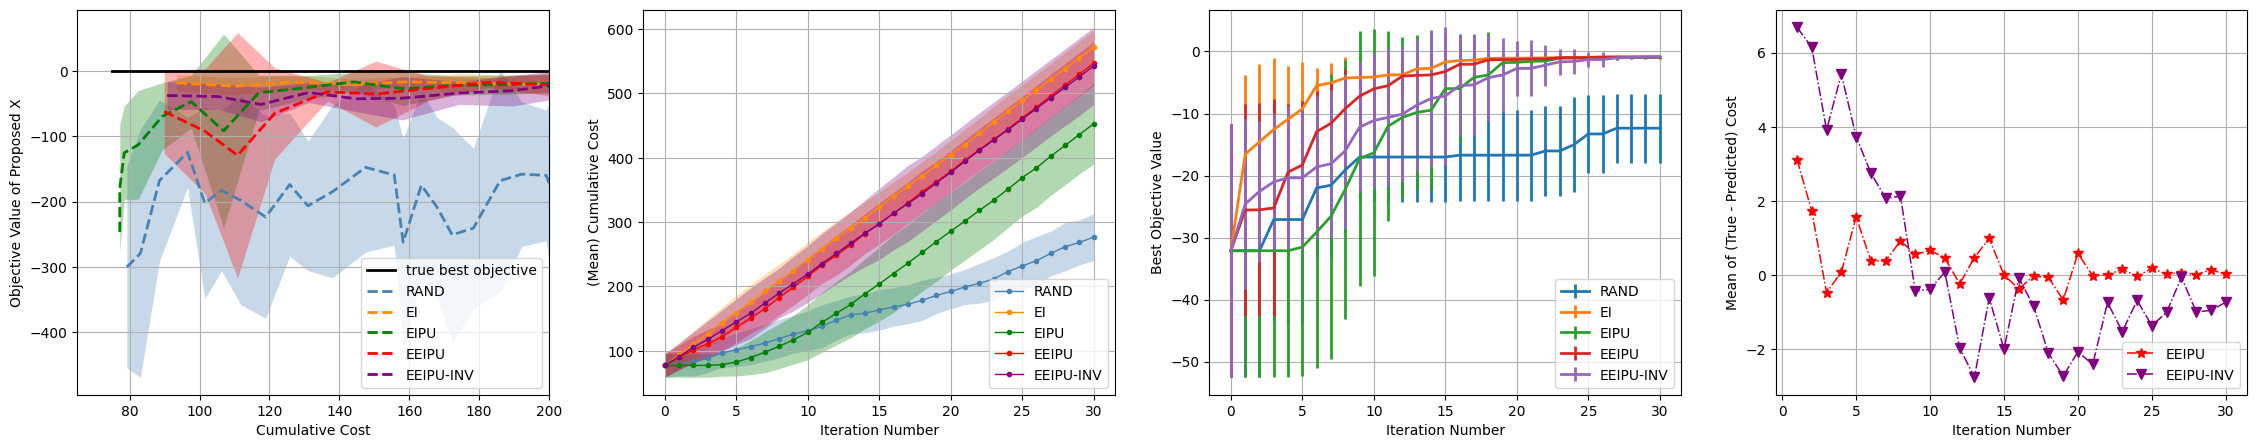

In [21]:
# from botorch.test_functions.hartmann6 import GLOBAL_MAXIMUM

%matplotlib inline
def ci(y):
    # return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)
    return y.std(axis=0) 

# GLOBAL_MAXIMUM = 3.32237
GLOBAL_MAXIMUM = 0
iters = np.arange(main_cfg['n_iters']+1) * main_cfg['batch_size']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 5))

# ax3.plot([0, main_cfg['n_iters'] * main_cfg['batch_size'] ], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)
ax1.plot([75, plot_vals[type_]['c(c)'][:,1:].max()], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)

types = ['RAND', 'EI', 'EIPU','EEIPU','EEIPU-INV',] 
cost_types = ['EEIPU','EEIPU-INV',] 
colors = {'RAND':'steelblue', 'EI':'darkorange', 'EIPU':'green','EEIPU':'red','EEIPU-INV':'purple'}
markers = {'RAND':'o', 'EI':'x', 'EIPU':'^','EEIPU':'*','EEIPU-INV':'v'}

for type_ in types:
    ## Plot 1 - Type 1
    ax1.plot(plot_vals[type_]['c(c)'][:,1:].mean(axis=0), plot_vals[type_]['f(x)'].mean(axis=0), 
              label=type_, linewidth=2, color=colors[type_], linestyle='--', markersize=8) 
    ax1.fill_between(plot_vals[type_]['c(c)'][:,1:].mean(axis=0), 
                     y1=plot_vals[type_]['f(x)'].mean(axis=0)+ci(plot_vals[type_]['f(x)']), 
                     y2=plot_vals[type_]['f(x)'].mean(axis=0)-ci(plot_vals[type_]['f(x)']),
                     color=colors[type_], alpha=.3, linewidth=0)
    ## Plot 1 - Type 2
    # ax1.plot(plot_vals[type_]['c(c)'].mean(axis=0), plot_vals[type_]['f(x^)'].mean(axis=0), 
    #           label=type_, linewidth=1.5, color=colors[type_], linestyle='--', markersize=8) 
    # ax1.fill_between(plot_vals[type_]['c(c)'].mean(axis=0), 
    #                  y1=plot_vals[type_]['f(x^)'].mean(axis=0)+ci(plot_vals[type_]['f(x^)']), 
    #                  y2=plot_vals[type_]['f(x^)'].mean(axis=0)-ci(plot_vals[type_]['f(x^)']),
    #                  color=colors[type_], alpha=.3, linewidth=0)
    
    ## Plot 1 - Type 3
    # for i in range(2):
    #     ax1.plot(plot_vals[type_]['c(c)'][i], plot_vals[type_]['f(x)'][i], 
    #           label=None, linewidth=.5, color=colors[type_]) 
    ax1.set_xlim(left=65); ax1.set_xlim(right=200)
    # ax1.set_ylim(bottom=-100);  
    ax1.grid() 
    
    ## Plot 2
    # Can exclude cumumulative cost of random warmup points using `[:,1:]`, of course
    ax2.plot(iters, plot_vals[type_]['c(c)'].mean(axis=0), label=type_, linewidth=1, color=colors[type_],marker=".")
    ax2.fill_between(iters, y1=plot_vals[type_]['c(c)'].mean(axis=0)+ci(plot_vals[type_]['c(c)']), 
                 y2= plot_vals[type_]['c(c)'].mean(axis=0)-ci(plot_vals[type_]['c(c)']),
                 color=colors[type_], alpha=.3, linewidth=0)
    ax2.grid()
    
    ## Plot 3
    ax3.errorbar(iters, plot_vals[type_]['f(x^)'].mean(axis=0), 
               yerr=ci(plot_vals[type_]['f(x^)']), label=type_, linewidth=2) 
    ax3.grid()
    
    ## Plot 4
    if type_ in cost_types:
        print("SHAPES!", plot_vals[type_]['mc(x)'].shape)
        pred_cost = plot_vals[type_]['mc(x)'] if type_=="EEIPU" else (1/plot_vals[type_]['mc(x)'])
        ax4.plot(iters[1:], (plot_vals[type_]['c(x)'] - pred_cost).mean(axis=0), 
              label=type_, linewidth=1.1, color=colors[type_], marker=markers[type_], linestyle='-.', markersize=7)  
    ax4.grid()

ax1.set(xlabel='Cumulative Cost', ylabel='Objective Value of Proposed X')
ax1.legend(loc="lower right") 
ax2.set(xlabel='Iteration Number', ylabel='(Mean) Cumulative Cost')
ax2.legend(loc="lower right")  
ax3.set(xlabel='Iteration Number', ylabel='Best Objective Value')
ax3.legend(loc="lower right")
ax4.set(xlabel='Iteration Number', ylabel='Mean of (True - Predicted) Cost')
ax4.legend(loc="lower right") 
 

## Random Tests

In [11]:
from botorch.test_functions import Branin
# neg_branin2 = Branin(negate=True)
# neg_branin2(torch.tensor([6, 5])) + neg_branin2(torch.tensor([2, 10]))


# neg_beale2 = Beale(negate=True); neg_hartmann3 = Hartmann(dim=3, negate=True);   
# neg_beale2(torch.tensor([float(6), float(5)])) + neg_hartmann3(torch.tensor([float(2), float(7), float(1)])) + neg_beale2(torch.tensor([float(2), float(3)]))


# neg_branin2 = Branin(negate=True); neg_hartmann6 = Hartmann(negate=True);   
# neg_branin2(torch.tensor([float(1), float(1)])) + neg_hartmann6(torch.tensor([float(2), float(0.5), float(1.5), float(1),float(0.2),float(0.2)]))

-torch.linalg.vector_norm(torch.tensor([6, 5, 2], dtype=float))

tensor(-8.0623, dtype=torch.float64)